# Model Comparison & Optimization

Ten notebook rozwija model bazowy z etapu *Baseline*.

Celem nie jest „pobić wynik za wszelką cenę”, ale świadomie dostroić model
do realnego celu biznesowego: lepszego wykrywania klientów wysokiego ryzyka
(Default = 1).

W kolejnych krokach:

1. Sprawdzimy wpływ zmiany progu decyzyjnego (0.5 → 0.4 → 0.3)  
   – jak zmienia się kompromis między precision i recall dla klasy Default.

2. Wprowadzimy wagi klas (`scale_pos_weight`) w XGBoost,  
   aby model bardziej „karał” błędy na klasie wysokiego ryzyka.

3. Porównamy wyniki z baseline’em i ocenimy,  
   które ustawienia są bardziej użyteczne z perspektywy biznesowej.

Ten etap pokazuje proces iteracyjny typowy dla pracy data scientist:
najpierw punkt odniesienia, potem świadome usprawnienia z jasno określonym celem.


In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve,
    classification_report, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


In [2]:
RANDOM_STATE = 42
target = "Default"

num_features = [
    "Age", "Income", "CreditScore", "LoanAmount",
    "EmploymentYears", "NumDependents", "DebtToIncome", "EducationLevel",
    "Income_per_Dependent", "Loan_to_Income", "Employment_Ratio"
]

cat_features = ["FavoriteColor", "Hobby"]


In [3]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["Income_per_Dependent"] = df["Income"] / (df["NumDependents"].fillna(0) + 1)

    income = df["Income"].replace(0, np.nan)
    df["Loan_to_Income"] = df["LoanAmount"] / income

    age = df["Age"].replace(0, np.nan)
    df["Employment_Ratio"] = df["EmploymentYears"] / age

    df = df.replace([np.inf, -np.inf], np.nan)
    return df


In [4]:
train_df = pd.read_parquet("train.parquet")
test_df  = pd.read_parquet("test.parquet")

train_df = prepare_data(train_df)
test_df  = prepare_data(test_df)

X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

print("OK. X_train:", X_train.shape, "X_test:", X_test.shape)


OK. X_train: (20000, 13) X_test: (5000, 13)


In [5]:
def build_pipeline_xgb(scale_pos_weight: float = 1.0, random_state: int = 42) -> Pipeline:
    num_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ])

    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=random_state,
        scale_pos_weight=scale_pos_weight
    )

    return Pipeline([("prep", preprocessor), ("model", model)])


def evaluate_model(pipe: Pipeline, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> dict:
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    roc = roc_auc_score(y_test, y_proba)
    pr  = average_precision_score(y_test, y_proba)

    print(f"Threshold: {threshold:.2f}")
    print("ROC-AUC:", roc)
    print("PR-AUC :", pr)
    print(classification_report(y_test, y_pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    return {"threshold": threshold, "roc_auc": roc, "pr_auc": pr}


W tym etapie nie zmieniamy jeszcze samego modelu, tylko sposób podejmowania decyzji.
Sprawdzamy, jak zmiana progu klasyfikacji (z domyślnego 0.5 na 0.4 i 0.3) wpływa na kompromis między:

- wykrywaniem klientów wysokiego ryzyka (recall klasy Default),

- a liczbą fałszywych alarmów (spadek precision).

To symuluje realną decyzję biznesową:
czy wolimy „przepuścić” część ryzykownych klientów, czy raczej odrzucić więcej bezpiecznych, aby złapać jak najwięcej potencjalnych defaultów?
Dzięki temu pokazujemy, że model to nie tylko liczba ROC-AUC, ale narzędzie, które można dostroić do strategii firmy.

Threshold: 0.50
ROC-AUC: 0.8012061588103254
PR-AUC : 0.6810136822796821
              precision    recall  f1-score   support

           0      0.773     0.844     0.807      3240
           1      0.654     0.544     0.594      1760

    accuracy                          0.738      5000
   macro avg      0.714     0.694     0.700      5000
weighted avg      0.731     0.738     0.732      5000



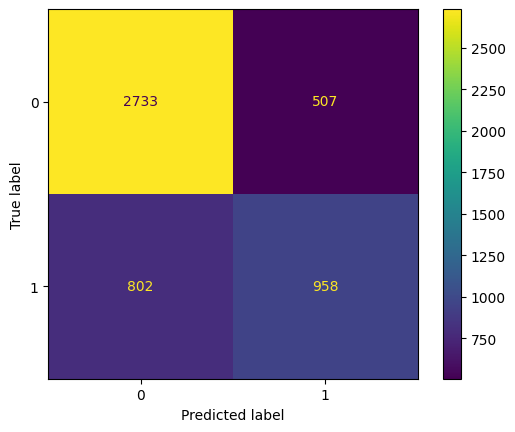

Threshold: 0.40
ROC-AUC: 0.8012061588103254
PR-AUC : 0.6810136822796821
              precision    recall  f1-score   support

           0      0.810     0.754     0.781      3240
           1      0.598     0.674     0.634      1760

    accuracy                          0.726      5000
   macro avg      0.704     0.714     0.707      5000
weighted avg      0.735     0.726     0.729      5000



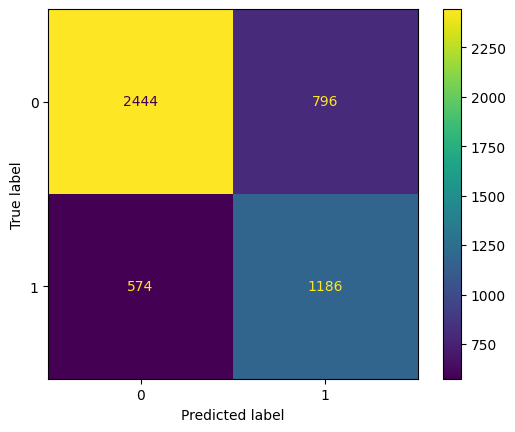

Threshold: 0.30
ROC-AUC: 0.8012061588103254
PR-AUC : 0.6810136822796821
              precision    recall  f1-score   support

           0      0.860     0.632     0.728      3240
           1      0.544     0.810     0.651      1760

    accuracy                          0.695      5000
   macro avg      0.702     0.721     0.690      5000
weighted avg      0.749     0.695     0.701      5000



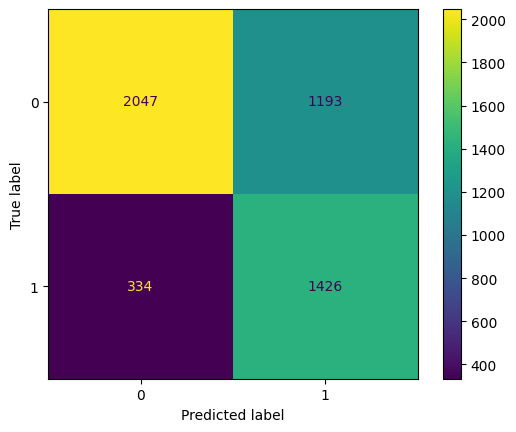

In [6]:
# 1) Model bazowy (bez wag klas) + porównanie progów
pipe_base = build_pipeline_xgb(scale_pos_weight=1.0, random_state=RANDOM_STATE)
pipe_base.fit(X_train, y_train)

for thr in [0.5, 0.4, 0.3]:
    _ = evaluate_model(pipe_base, X_test, y_test, threshold=thr)


Zmiana progu nie wpływa na zdolność modelu do rozróżniania klas (ROC-AUC i PR-AUC pozostają identyczne),
ale istotnie zmienia sposób podejmowania decyzji:

- Przy progu 0.50 model jest „ostrożny” – ma wyższą precyzję dla klasy Default, ale wykrywa tylko ~54% ryzykownych klientów.

- Przy progu 0.40 recall klasy Default rośnie do ~67% kosztem spadku precision – model zaczyna łapać więcej potencjalnych problemów.

- Przy progu 0.30 model wykrywa już ~81% przypadków defaultu, ale generuje znacznie więcej fałszywych alarmów.

Pokazuje to, że model można dostroić do strategii firmy:

- konserwatywnej (mniej odrzuceń, więcej ryzyka),

- lub defensywnej (więcej odrzuceń, mniejsze ryzyko strat).

Sam algorytm pozostaje ten sam – zmienia się tylko sposób wykorzystania jego predykcji w procesie decyzyjnym.

In [7]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight


1.9141774734081305

In [8]:
pipe_weighted = build_pipeline_xgb(
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE
)

pipe_weighted.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

Threshold: 0.50
ROC-AUC: 0.8007320601851852
PR-AUC : 0.6869164471428231
              precision    recall  f1-score   support

           0      0.834     0.695     0.758      3240
           1      0.570     0.745     0.646      1760

    accuracy                          0.713      5000
   macro avg      0.702     0.720     0.702      5000
weighted avg      0.741     0.713     0.719      5000



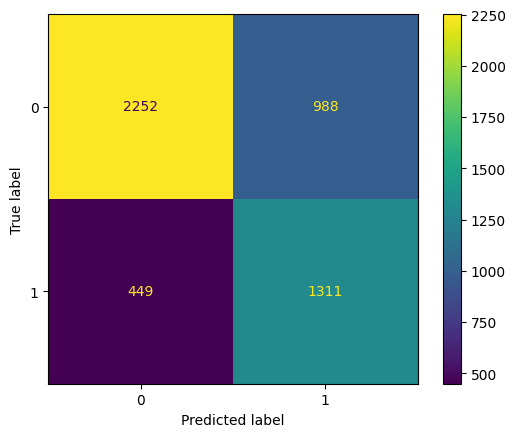

Threshold: 0.40
ROC-AUC: 0.8007320601851852
PR-AUC : 0.6869164471428231
              precision    recall  f1-score   support

           0      0.873     0.578     0.695      3240
           1      0.521     0.845     0.645      1760

    accuracy                          0.672      5000
   macro avg      0.697     0.712     0.670      5000
weighted avg      0.749     0.672     0.678      5000



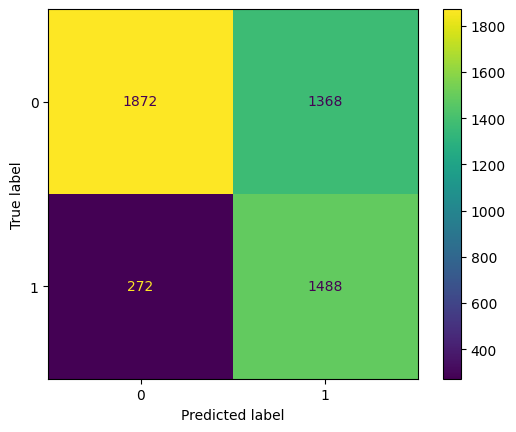

Threshold: 0.30
ROC-AUC: 0.8007320601851852
PR-AUC : 0.6869164471428231
              precision    recall  f1-score   support

           0      0.910     0.473     0.622      3240
           1      0.485     0.914     0.633      1760

    accuracy                          0.628      5000
   macro avg      0.697     0.693     0.628      5000
weighted avg      0.760     0.628     0.626      5000



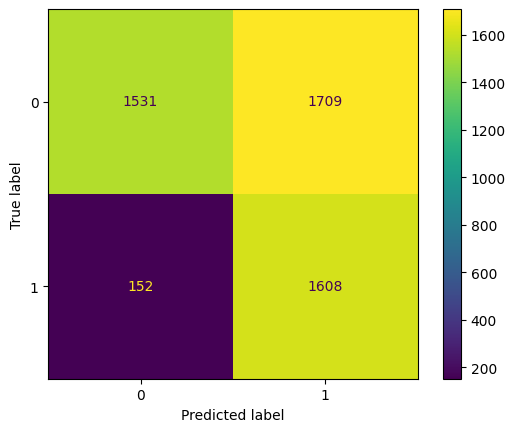

In [9]:
for thr in [0.5, 0.4, 0.3]:
    _ = evaluate_model(pipe_weighted, X_test, y_test, threshold=thr)


## Im niższy próg i im bardziej ważymy klasę pozytywną, tym więcej ryzyka wykrywamy – ale kosztem większej liczby fałszywych alarmów.

## Model War – strategie decyzyjne

Poniżej porównano różne konfiguracje modelu:

- Baseline (threshold 0.5)
- Baseline (threshold 0.4)
- Weighted XGB (threshold 0.5)
- Weighted XGB (threshold 0.35)

Każda z nich reprezentuje inną politykę ryzyka.


In [10]:
results = []

configs = [
    ("Baseline", pipe_base, 0.5),
    ("Baseline", pipe_base, 0.4),
    ("Weighted", pipe_weighted, 0.5),
    ("Weighted", pipe_weighted, 0.35),
]

for name, pipe, thr in configs:
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= thr).astype(int)

    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        "Model": name,
        "Threshold": thr,
        "Recall_Default": report["1"]["recall"],
        "Precision_Default": report["1"]["precision"],
        "F1_Default": report["1"]["f1-score"],
        "Accuracy": report["accuracy"],
    })

pd.DataFrame(results)


,Model,Threshold,Recall_Default,Precision_Default,F1_Default,Accuracy
0,Baseline,0.50,0.544318,0.653925,0.594109,0.7382
1,Baseline,0.40,0.673864,0.598385,0.633886,0.7260
2,Weighted,0.50,0.744886,0.570248,0.645972,0.7126
3,Weighted,0.35,0.888636,0.503542,0.642828,0.6524


Model nie ma jednej „najlepszej” konfiguracji – każda z nich reprezentuje inną strategię biznesową.
Jeśli celem jest maksymalne ograniczenie strat finansowych, konfiguracja Weighted @ 0.35 jest najbardziej agresywna i wykrywa niemal 90% przypadków defaultu.
Jeśli ważniejsza jest dostępność kredytu i doświadczenie klienta, bardziej umiarkowane ustawienia (Baseline @ 0.40 lub Weighted @ 0.50) oferują lepszy kompromis.

Nie wybrałem jednego ‘najlepszego’ modelu – zaprojektowałem cztery polityki ryzyka i pokazałem ich konsekwencje.

## Hyperparameter Tuning – poprawa jakości modelu

Na tym etapie celem nie jest jeszcze wybór progu decyzyjnego,
lecz maksymalizacja zdolności modelu do rozróżniania klientów
bezpiecznych i ryzykownych (ROC-AUC / PR-AUC).

Najpierw budujemy możliwie najlepszy model rankingowy,
a dopiero potem projektujemy politykę decyzji.


In [11]:
from sklearn.model_selection import RandomizedSearchCV

pipe_tune = build_pipeline_xgb(
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE
)

param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
    "model__min_child_weight": [1, 5, 10],
    "model__gamma": [0, 0.5, 1.0],
}

search = RandomizedSearchCV(
    pipe_tune,
    param_distributions=param_grid,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
search.best_score_, search.best_params_


Fitting 3 folds for each of 25 candidates, totalling 75 fits


(0.8065856193512456,
 {'model__subsample': 0.7,
  'model__n_estimators': 200,
  'model__min_child_weight': 10,
  'model__max_depth': 3,
  'model__learning_rate': 0.03,
  'model__gamma': 0,
  'model__colsample_bytree': 0.7})

Threshold: 0.50
ROC-AUC: 0.8044027076318743
PR-AUC : 0.6876803514355366
              precision    recall  f1-score   support

           0      0.843     0.674     0.749      3240
           1      0.562     0.769     0.649      1760

    accuracy                          0.708      5000
   macro avg      0.703     0.722     0.699      5000
weighted avg      0.744     0.708     0.714      5000



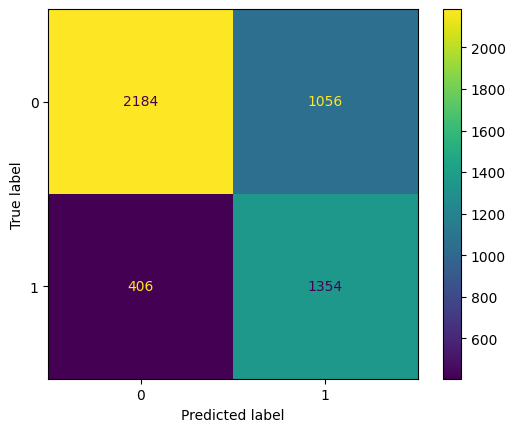

In [12]:
best_model = search.best_estimator_
_ = evaluate_model(best_model, X_test, y_test, threshold=0.5)


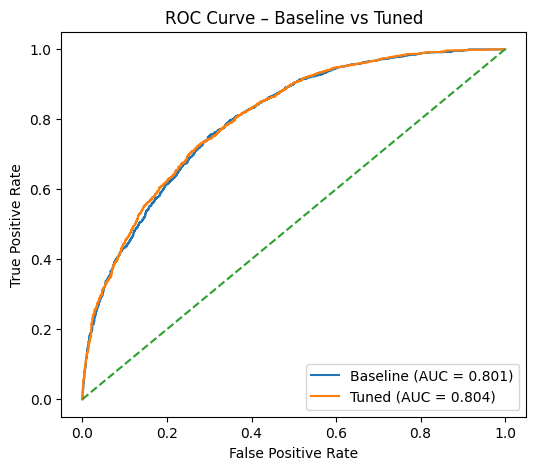

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba_baseline = pipe_base.predict_proba(X_test)[:, 1]
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_baseline)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)

roc_auc_base = auc(fpr_base, tpr_base)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure(figsize=(6, 5))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {roc_auc_base:.3f})")
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned (AUC = {roc_auc_tuned:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Baseline vs Tuned")
plt.legend(loc="lower right")

plt.savefig("docs/img/roc_baseline_vs_tuned.png", dpi=150, bbox_inches="tight")
plt.show()


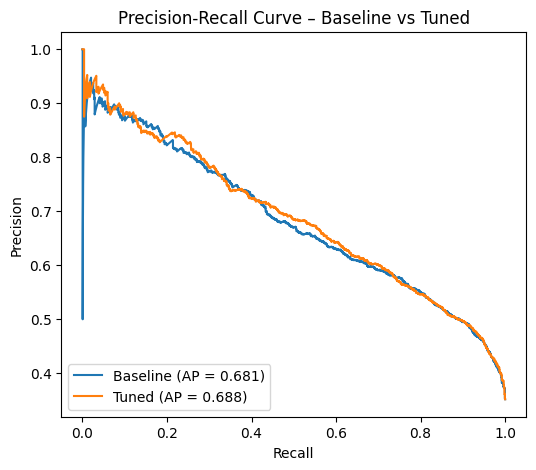

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Precision-Recall: baseline vs tuned
prec_base, rec_base, _ = precision_recall_curve(y_test, y_proba_baseline)
prec_tuned, rec_tuned, _ = precision_recall_curve(y_test, y_proba_tuned)

ap_base = average_precision_score(y_test, y_proba_baseline)
ap_tuned = average_precision_score(y_test, y_proba_tuned)

plt.figure(figsize=(6, 5))
plt.plot(rec_base, prec_base, label=f"Baseline (AP = {ap_base:.3f})")
plt.plot(rec_tuned, prec_tuned, label=f"Tuned (AP = {ap_tuned:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Baseline vs Tuned")
plt.legend(loc="lower left")

plt.savefig("docs/img/pr_baseline_vs_tuned.png", dpi=150, bbox_inches="tight")
plt.show()


Threshold: 0.50
ROC-AUC: 0.8044027076318743
PR-AUC : 0.6876803514355366
              precision    recall  f1-score   support

           0      0.843     0.674     0.749      3240
           1      0.562     0.769     0.649      1760

    accuracy                          0.708      5000
   macro avg      0.703     0.722     0.699      5000
weighted avg      0.744     0.708     0.714      5000



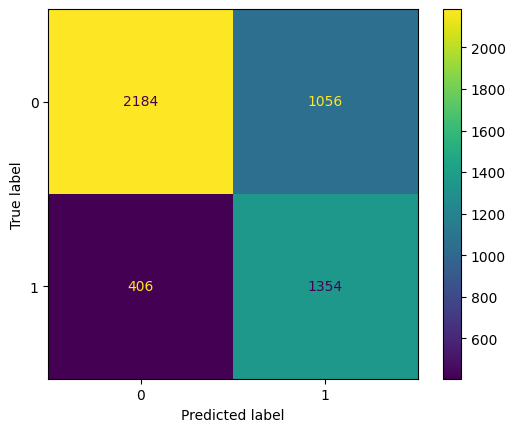

Threshold: 0.40
ROC-AUC: 0.8044027076318743
PR-AUC : 0.6876803514355366
              precision    recall  f1-score   support

           0      0.885     0.538     0.669      3240
           1      0.506     0.871     0.640      1760

    accuracy                          0.655      5000
   macro avg      0.695     0.705     0.655      5000
weighted avg      0.752     0.655     0.659      5000



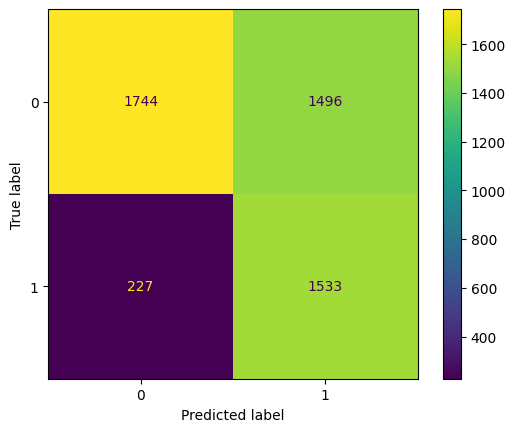

Threshold: 0.35
ROC-AUC: 0.8044027076318743
PR-AUC : 0.6876803514355366
              precision    recall  f1-score   support

           0      0.907     0.492     0.638      3240
           1      0.492     0.907     0.638      1760

    accuracy                          0.638      5000
   macro avg      0.700     0.700     0.638      5000
weighted avg      0.761     0.638     0.638      5000



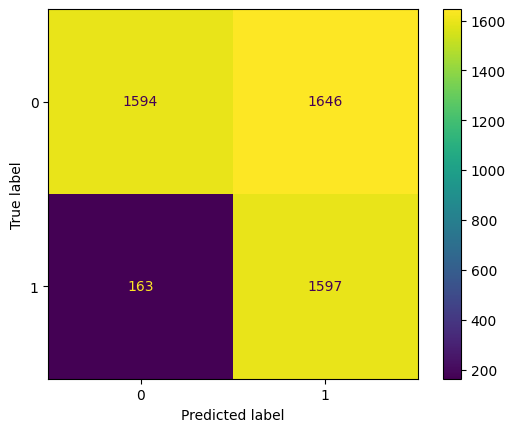

Threshold: 0.30
ROC-AUC: 0.8044027076318743
PR-AUC : 0.6876803514355366
              precision    recall  f1-score   support

           0      0.921     0.447     0.602      3240
           1      0.477     0.930     0.631      1760

    accuracy                          0.617      5000
   macro avg      0.699     0.688     0.616      5000
weighted avg      0.765     0.617     0.612      5000



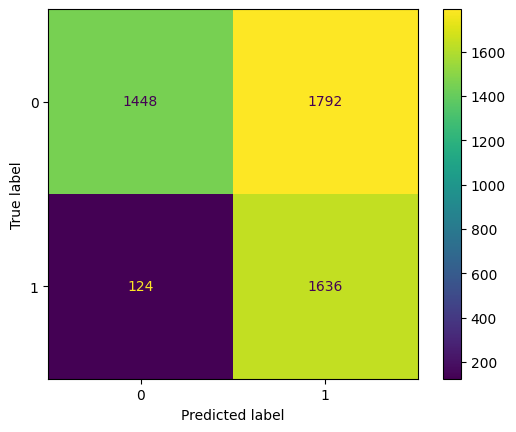

In [18]:
for thr in [0.5, 0.4, 0.35, 0.3]:
    _ = evaluate_model(best_model, X_test, y_test, threshold=thr)


<Figure size 500x400 with 0 Axes>

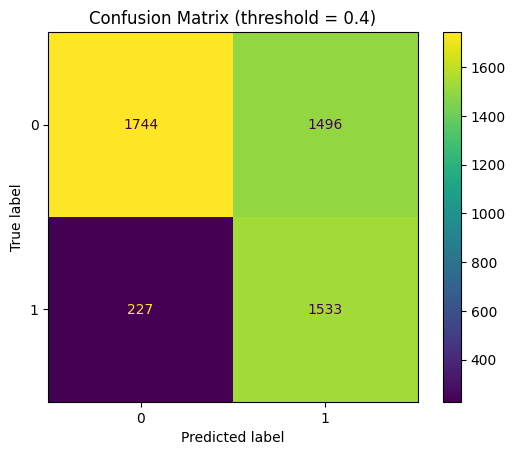

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

chosen_thr = 0.40  # możesz zmienić na 0.35, jeśli ten próg lepiej pasuje biznesowo

y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= chosen_thr).astype(int)

plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix (threshold = {chosen_thr})")

plt.savefig("docs/img/confusion_matrix_040.png", dpi=150, bbox_inches="tight")
plt.show()


Dla progu decyzyjnego 0.40 model osiąga następujący rozkład decyzji:

- **True Negative (1744)** – poprawnie zaakceptowani klienci niskiego ryzyka,  
- **False Positive (1496)** – klienci bezpieczni, którzy zostali niepotrzebnie odrzuceni,  
- **False Negative (227)** – klienci wysokiego ryzyka przepuszczeni przez system (najdroższy błąd),  
- **True Positive (1533)** – poprawnie wykryci klienci, którzy nie spłacą zobowiązania.

Macierz pokazuje, że obniżenie progu do 0.40 znacząco redukuje liczbę najdroższych błędów (FN), kosztem wzrostu liczby fałszywych alarmów (FP). W praktyce oznacza to przesunięcie polityki decyzyjnej w stronę większej ostrożności – bank traci część potencjalnych klientów, ale ogranicza ekspozycję na realne straty finansowe.


- 0.50 – model zachowuje rozsądny balans:

„Wykrywamy ~77% niespłacających klientów przy umiarkowanej liczbie fałszywych alarmów.”

- 0.40 – wersja „risk-oriented”:

„Wykrywamy już 87% ryzykownych klientów, kosztem większej liczby błędnych odrzuceń.”

- 0.35 / 0.30 – tryb „ochrona portfela za wszelką cenę”:

„Lepiej odrzucić zbyt wielu niż przepuścić defaulterów.”

In [ ]:
Model po tuningu osiąga ROC-AUC ≈ 0.80, co oznacza dobrą zdolność rankingową.
Ostateczna decyzja zależy od progu decyzyjnego:

threshold = 0.50 – kompromis między ryzykiem a dostępnością kredytu

threshold = 0.40 – strategia nastawiona na minimalizację strat

threshold ≤ 0.35 – scenariusz kryzysowy / defensywny